# **PCE Modeling**

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from numpy.polynomial import legendre
from sklearn.base import BaseEstimator, TransformerMixin
import itertools
from sklearn.model_selection import cross_val_score
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

input_folder = "/project2/zhan248_1326/hhao4018/UQ_analysis/HSI_Hourly_average_v4"            # 里面有 indices_Summer_HourXX.csv, indices_Winter_HourXX.csv
output_plot  = "/project2/zhan248_1326/hhao4018/UQ_analysis/PCE_HSI_Hourly_figures_v4"
os.makedirs(output_plot, exist_ok=True)

indices      =  ["ESI", "HI", "NET", "WBGT"]
seasons      = ["Summer"]

class OrthogonalPolynomialFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, degree=3, include_bias=True):
        self.degree = degree
        self.include_bias = include_bias
    def fit(self, X, y=None):
        X = np.asarray(X)
        self.X_min_, self.X_max_ = X.min(0), X.max(0)
        nfeat = X.shape[1]
        self.combinations_ = [
            comb for comb in itertools.product(range(self.degree+1), repeat=nfeat)
            if sum(comb)<=self.degree and (self.include_bias or sum(comb)>0)
        ]
        self.combinations_.sort(key=lambda c:(sum(c),c))
        return self
    def transform(self, X):
        X = np.asarray(X)
        n, d = X.shape
        Xs = np.zeros_like(X, dtype=float)
        for j in range(d):
            lo, hi = self.X_min_[j], self.X_max_[j]
            Xs[:,j] = (2*(X[:,j]-lo)/(hi-lo)-1) if hi>lo else 0
        vds = [legendre.legvander(Xs[:,j], self.degree) for j in range(d)]
        cols = []
        for comb in self.combinations_:
            arr = np.ones(n)
            for j,deg in enumerate(comb):
                arr *= vds[j][:,deg]
            cols.append(arr)
        return np.stack(cols,1)

Xinputs = pd.read_csv("UMP_100sampling_input.csv").iloc[:,1:4].to_numpy()
maskX   = ~np.isnan(Xinputs).any(axis=1)
Xinputs = Xinputs[maskX]

pce_stats = {season:{} for season in seasons}
hourly_r2 = {season: {idx: [] for idx in indices} for season in seasons}

for season in seasons:
    for hr in range(24):
        fpath = os.path.join(input_folder, f"indices_{season}_Hour{hr:02d}.csv")
        if not os.path.exists(fpath): 
            continue
        df = pd.read_csv(fpath)
        stats = {}
        for idx in indices:
            if idx not in df.columns:
                stats[idx] = {"mean": np.nan, "std": np.nan}
                continue
            y = df[idx].to_numpy()[maskX]
            if y.size < 10 or np.all(np.isnan(y)):
                stats[idx] = {"mean": np.nan, "std": np.nan}
                continue

            best_score = -np.inf
            best_deg   = 1
            for deg in range(1, 4):
                cv_pipe = Pipeline([
                    ("imputer", SimpleImputer(strategy="mean")),
                    ("poly",    OrthogonalPolynomialFeatures(degree=deg)),
                    ("reg",     LinearRegression())
                ])
                scores = cross_val_score(cv_pipe, Xinputs, y, cv=5, scoring="r2")
                mean_r2 = scores.mean()
                if mean_r2 > best_score:
                    best_score = mean_r2
                    best_deg   = deg
                hourly_r2[season][idx].append(best_score) 
            pipe = Pipeline([
                ("imputer", SimpleImputer(strategy="mean")),
                ("poly",    OrthogonalPolynomialFeatures(degree=best_deg)),
                ("reg",     LinearRegression())
            ])
            pipe.fit(Xinputs, y)
            reg    = pipe.named_steps["reg"]
            coefs  = reg.coef_
            combs  = pipe.named_steps["poly"].combinations_

            # PCE mean = intercept
            mu = reg.intercept_

            norms = []
            for comb in combs:
                nrm = 1.0
                for d in comb:
                    if d > 0:
                        nrm *= 2.0 / (2*d + 1)
                norms.append(nrm)
            norms = np.array(norms)

            var   = np.sum(coefs[1:]**2 * norms[1:]) / 2
            sigma = np.sqrt(var)

            stats[idx] = {
                "mean":    mu,
                "std":     sigma,
                "opt_deg": best_deg,
                "cv_r2":   best_score
            }

        pce_stats[season][hr] = stats


# **Plot SD hourly**

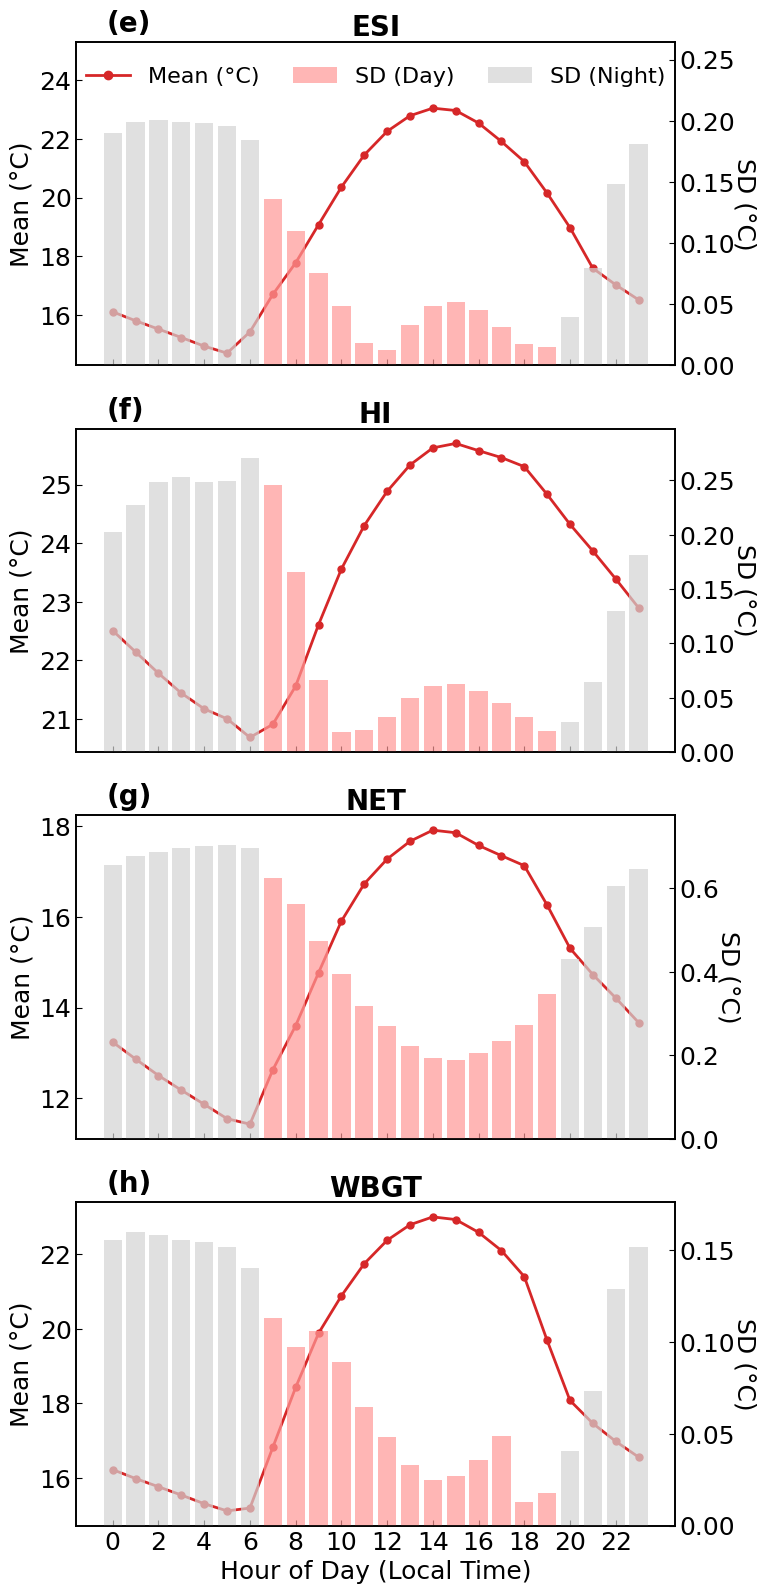

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.serif": ["Times New Roman"],
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "axes.grid": False,
    "axes.titlesize": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18,
})

colors = {"Summer": "#d62728"}
light_colors = {"Summer": "#ff9896"}

unit_lbl = {
    "ESI": "ESI °C",
    "WBGT": "WBGT °C",
    "HI":  "HI °C",
    "NET": "NET °C",
}

season = "Summer"
indices = ["ESI", "HI", "NET", "WBGT"]
labels = ["(e)", "(f)", "(g)", "(h)"] 

output_plot = "/project2/zhan248_1326/hhao4018/UQ_analysis/PCE_HSI_Hourly_figures_v4"
os.makedirs(output_plot, exist_ok=True)

fig, axes = plt.subplots(4, 1, figsize=(8, 16), sharex=True)

for i, (ax, idx, lab) in enumerate(zip(axes, indices, labels)):
    stds_all = np.array([
        pce_stats[season].get(h, {}).get(idx, {}).get("std", np.nan)
        for h in range(24)
    ])
    std_max = np.nanmax(stds_all)

    means = np.array([
        pce_stats[season].get(h, {}).get(idx, {}).get("mean", np.nan)
        for h in range(24)
    ])
    stds = np.array([
        pce_stats[season].get(h, {}).get(idx, {}).get("std", np.nan)
        for h in range(24)
    ])
    offset = -7
    local_h = np.mod(np.arange(24) + offset, 24)
    order = np.argsort(local_h)
    hours, m_vals, s_vals = local_h[order], means[order], stds[order]

    ax2 = ax.twinx()

    bar_colors = [
        light_colors[season] if 7 <= hour <= 19 else "lightgray"
        for hour in h0
    ]
    ax2.bar(
        hours, s_vals,
        color=bar_colors,
        width=0.8, alpha=0.7,
        zorder=1
    )
    
    if ax is axes[0]:      
        mean_label     = f"Mean ({unit_lbl[idx].split()[-1]})"
        std_label_day   = "SD (Day)"
        std_label_night = "SD (Night)"
        handles = [
            Line2D([0], [0], color=colors[season],     lw=2, marker="o", label=mean_label),
            Patch(facecolor=light_colors[season], alpha=0.7, label=std_label_day),
            Patch(facecolor="lightgray",            alpha=0.7, label=std_label_night),
        ]

        ax.legend(
            handles=handles,
            loc='lower center',          
            bbox_to_anchor=(0.5, 0.8),   
            ncol=3,
            frameon=False,
            fontsize=16,
            columnspacing=1.5,
        )

    
    ax2.set_ylim(0, std_max * 1.1)

    ax.plot(hours, m_vals,
            '-o',
            color=colors[season],
            lw=2,
            markersize=5,
            label=f"Mean ({unit_lbl[idx].split()[-1]})",
            zorder=2)
    
    if ax is axes[-1]:
        ax.set_xlabel("Hour of Day (Local Time)")
        ax.set_xticks(np.arange(0, 24, 2))
    else:
        ax.set_xticks([])

    ax.set_ylabel(f"Mean ({unit_lbl[idx].split()[-1]})")
    ax2.set_ylabel(f"SD ({unit_lbl[idx].split()[-1]})", rotation=270, labelpad=15)

    for spine in ['top', 'left', 'bottom', 'right']:
        ax.spines[spine].set_edgecolor('black')
        ax2.spines[spine].set_edgecolor('black')
        
    ax.set_title(idx, loc='center', pad=2, fontsize=20, fontweight='bold')
    ax.text(0.05, 1.1,
            lab,
            transform=ax.transAxes,
            fontsize=20,
            fontweight='bold',
            va='top',
            ha='left')
    
    if i == 0:
        y0, y1 = ax.get_ylim()
        span = y1 - y0
        ax.set_ylim(y0, y0 + span * 1.2)

        y2_0, y2_1 = ax2.get_ylim()
        span2 = y2_1 - y2_0
        ax2.set_ylim(y2_0, y2_0 + span2 * 1.2)

plt.tight_layout(h_pad=1.5)
plt.show()
fig.savefig(os.path.join(output_plot, f"PCE_hourly_summer_4x1.png"), dpi=600)
plt.close(fig)

# **R2**

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.serif": ["Times New Roman"],
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "axes.grid": False,
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
})

colors = {"Summer": "#d62728", "Winter": "#1f77b4"}
unit_official_names = {
    "ESI": "ESI",
    "ETm": "ETm",
    "HI":  "HI",
    "NET": "NET"
}

rows = []
for season in ["Summer", "Winter"]:
    for var, r2_vals in hourly_r2[season].items():
        vals = list(r2_vals) + [np.nan] * (24 - len(r2_vals))
        for hour, r2 in enumerate(vals):
            rows.append({
                "Season":   season,
                "Hour":     hour,
                "Variable": var,
                "R2":       r2
            })
df_r2 = pd.DataFrame(rows)

output_dir = "PCE_HSI_Hourly_figures_v2"
os.makedirs(output_dir, exist_ok=True)

for var in df_r2["Variable"].unique():
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    for ax, season in zip(axes, ["Summer", "Winter"]):
        sub = df_r2[(df_r2["Variable"] == var) & (df_r2["Season"] == season)]
        offset = -7 if season == "Summer" else -8
        hrs = np.mod(sub["Hour"].to_numpy() + offset, 24)
        idx = np.argsort(hrs)
        hrs_s = hrs[idx]
        r2_s  = sub["R2"].to_numpy()[idx]

        ax.bar(hrs_s, r2_s,
               color=colors[season],edgecolor='none',
               width=0.8, align="center")
        ax.set_xticks(np.arange(0, 24, 2))
        ax.set_xlabel("Hour (Local)")
        if ax is axes[0]:
            ax.set_ylabel("Cross-validated $R^2$")
            ax.text(-0.05, 1.12, unit_official_names.get(var, var),
                    transform=ax.transAxes,
                    fontsize=14, fontweight='bold',
                    va='bottom', ha='left')
    fig.suptitle(f"Hourly Cross-validated $R^2$ of {var}", fontsize=16, weight='bold', y=1.02)
    fig.tight_layout()
    out_fn = os.path.join(output_dir, f"{var}_Hourly_R2.png")
    fig.savefig(out_fn, dpi=300)
    plt.close(fig)
    print(f"Saved plot for {var} -> {out_fn}")


Saved plot for ESI -> PCE_HSI_Hourly_figures_v2/ESI_Hourly_R2.png
Saved plot for ETm -> PCE_HSI_Hourly_figures_v2/ETm_Hourly_R2.png
Saved plot for HI -> PCE_HSI_Hourly_figures_v2/HI_Hourly_R2.png
Saved plot for NET -> PCE_HSI_Hourly_figures_v2/NET_Hourly_R2.png
